# SAM8905 Reverb FX - ALG 1 Analysis (Diffusion)

This notebook analyzes ALG 1 of the Keyfox10 reverb effect.

**ALG 1 Purpose:** Diffusion/scatter processing - spreads early reflections for a more natural reverb sound.

**Key characteristics:**
- Located at A-RAM 0x40-0x7F (22kHz ALG 1)
- Used by Slot 5 (D-RAM ALG=2)
- Heavy DAC output: 13 WACC instructions
- No WXY+WSP combo (uses MIX values from previous slot)
- Reads from D-RAM and SRAM for extensive multiply-accumulate operations

In [29]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import sam8905_interpreter
reload(sam8905_interpreter)

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## ALG 1 from Keyfox10 FX Chip

A-RAM addresses 0x40-0x7F (64 instructions for 22kHz ALG 1)

In [30]:
# A-RAM 0x40-0x7F: 22kHz ALG 1 (D-RAM ALG=2, Used by Slot 5 - Diffusion)
# From WIP_fx_reverb_analysis.md
aram_alg1 = [
    0x30EF,  # PC00: RM 6, <WPHI>                      - PHI = D[6]
    0x48FD,  # PC01: RM 9, <WWF>                       - WWF = D[9] (waveform config)
    0x6ADF,  # PC02: RADD 13, <WM>                     - D[13] = A+B
    0x703F,  # PC03: RM 14, <WA, WB>                   - A=B=D[14]
    0x0000,  # PC04: RM 0, <WA,WB,WM,WPHI,WXY,clrB,WWF,WACC>  - WACC #1
    0x6BDF,  # PC05: RADD 13, <WM> [WSP]               - D[13] = A+B, WSP active
    0x38EF,  # PC06: RM 7, <WPHI>                      - PHI = D[7]
    0x50FC,  # PC07: RM 10, <WWF,WACC>                 - WWF=D[10], WACC #2
    0x687F,  # PC08: RM 13, <WA>                       - A = D[13]
    0x7CBE,  # PC09: RP 15, <WB,WACC>                  - B = product, WACC #3
    0x18F7,  # PC10: RM 3, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC11: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC12: RM 8, <WPHI>                      - PHI = D[8]
    0x58FC,  # PC13: RM 11, <WWF,WACC>                 - WWF=D[11], WACC #4
    0x7CBE,  # PC14: RP 15, <WB,WACC>                  - B = product, WACC #5
    0x6ADF,  # PC15: RADD 13, <WM>                     - D[13] = A+B
    0x18F7,  # PC16: RM 3, <WXY>                       - WXY - waveform read
    0x00BF,  # PC17: RM 0, <WB>                        - B = D[0]
    0x307F,  # PC18: RM 6, <WA>                        - A = D[6]
    0x32CE,  # PC19: RADD 6, <WM,WPHI,WACC>            - D[6]=A+B, PHI=bus, WACC #6
    0x48FC,  # PC20: RM 9, <WWF,WACC>                  - WWF=D[9], WACC #7
    0x387F,  # PC21: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC22: RADD 7, <WM>                      - D[7] = A+B
    0x407F,  # PC23: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC24: RADD 8, <WM>                      - D[8] = A+B
    0x7CBF,  # PC25: RP 15, <WB>                       - B = product
    0x20F7,  # PC26: RM 4, <WXY>                       - WXY - waveform read
    0x687F,  # PC27: RM 13, <WA>                       - A = D[13]
    0x38EF,  # PC28: RM 7, <WPHI>                      - PHI = D[7]
    0x50FD,  # PC29: RM 10, <WWF>                      - WWF = D[10]
    0x7A7E,  # PC30: RADD 15, <WA,WACC>                - A=A+B, WACC #8
    0x7CBE,  # PC31: RP 15, <WB,WACC>                  - B = product, WACC #9
    0x28F7,  # PC32: RM 5, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC33: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC34: RM 8, <WPHI>                      - PHI = D[8]
    0x58FD,  # PC35: RM 11, <WWF>                      - WWF = D[11]
    0x7CBE,  # PC36: RP 15, <WB,WACC>                  - B = product, WACC #10
    0x6ADE,  # PC37: RADD 13, <WM,WACC>                - D[13]=A+B, WACC #11
    0x28F7,  # PC38: RM 5, <WXY>                       - WXY - waveform read
    0x08BF,  # PC39: RM 1, <WB>                        - B = D[1]
    0x307F,  # PC40: RM 6, <WA>                        - A = D[6]
    0x32DF,  # PC41: RADD 6, <WM>                      - D[6] = A+B
    0x493F,  # PC42: RM 9, <WA,WB> [WSP]               - A=B=D[9], WSP active
    0x4ADF,  # PC43: RADD 9, <WM>                      - D[9] = A+B
    0x60BF,  # PC44: RM 12, <WB>                       - B = D[12]
    0x4BDF,  # PC45: RADD 9, <WM> [WSP]                - D[9]=A+B, WSP active
    0x08BF,  # PC46: RM 1, <WB>                        - B = D[1]
    0x387F,  # PC47: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC48: RADD 7, <WM>                      - D[7] = A+B
    0x513F,  # PC49: RM 10, <WA,WB> [WSP]              - A=B=D[10], WSP active
    0x52DF,  # PC50: RADD 10, <WM>                     - D[10] = A+B
    0x60BF,  # PC51: RM 12, <WB>                       - B = D[12]
    0x53DF,  # PC52: RADD 10, <WM> [WSP]               - D[10]=A+B, WSP active
    0x08BF,  # PC53: RM 1, <WB>                        - B = D[1]
    0x407F,  # PC54: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC55: RADD 8, <WM>                      - D[8] = A+B
    0x593F,  # PC56: RM 11, <WA,WB> [WSP]              - A=B=D[11], WSP active
    0x5ADF,  # PC57: RADD 11, <WM>                     - D[11] = A+B
    0x60BF,  # PC58: RM 12, <WB>                       - B = D[12]
    0x5BDF,  # PC59: RADD 11, <WM> [WSP]               - D[11]=A+B, WSP active
    0x7CBE,  # PC60: RP 15, <WB,WACC>                  - B = product, WACC #12
    0x687E,  # PC61: RM 13, <WA,WACC>                  - A = D[13], WACC #13
]

# Pad to 64 instructions (PC62-63 are reserved NOPs)
aram_alg1 += [0x7FFF] * (64 - len(aram_alg1))

print(f"ALG 1: {len(aram_alg1)} instructions")
print()
print(decode_algorithm(aram_alg1, 1))

ALG 1: 64 instructions

=== Algorithm 1 ===

PC00: 30EF  RM 6, <WPHI>
PC01: 48FD  RM 9, <WWF>
PC02: 6ADF  RADD 13, <WM>
PC03: 703F  RM 14, <WA, WB>
PC04: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
PC05: 6BDF  RADD 13, <WM, WSP> ***
PC06: 38EF  RM 7, <WPHI>
PC07: 50FC  RM 10, <WWF, WACC>
PC08: 687F  RM 13, <WA>
PC09: 7CBE  RP, <WB, WACC>
PC10: 18F7  RM 3, <WXY>
PC11: 7A7F  RADD, <WA>
PC12: 40EF  RM 8, <WPHI>
PC13: 58FC  RM 11, <WWF, WACC>
PC14: 7CBE  RP, <WB, WACC>
PC15: 6ADF  RADD 13, <WM>
PC16: 18F7  RM 3, <WXY>
PC17: 00BF  RM 0, <WB>
PC18: 307F  RM 6, <WA>
PC19: 32CE  RADD 6, <WM, WPHI, WACC>
PC20: 48FC  RM 9, <WWF, WACC>
PC21: 387F  RM 7, <WA>
PC22: 3ADF  RADD 7, <WM>
PC23: 407F  RM 8, <WA>
PC24: 42DF  RADD 8, <WM>
PC25: 7CBF  RP, <WB>
PC26: 20F7  RM 4, <WXY>
PC27: 687F  RM 13, <WA>
PC28: 38EF  RM 7, <WPHI>
PC29: 50FD  RM 10, <WWF>
PC30: 7A7E  RADD, <WA, WACC>
PC31: 7CBE  RP, <WB, WACC>
PC32: 28F7  RM 5, <WXY>
PC33: 7A7F  RADD, <WA>
PC34: 40EF  RM 8, <WPHI>
PC35: 58FD  R

## D-RAM Configuration (Slot 5 - Diffusion)

In [31]:
# D-RAM for Slot 5 (ALG 1 / Diffusion)
# From WIP_fx_reverb_analysis.md
dram_slot5 = [
    0x00080,  # word 0: PHI offset / constant
    0x00180,  # word 1: Modulation offset
    0x1003F,  # word 2: WWF config (external waveform)
    0x10000,  # word 3: Amplitude coefficient
    0x00100,  # word 4: Delay line address
    0x00100,  # word 5: Delay line address 2
    0x3FF00,  # word 6: Large delay address
    0x6DF00,  # word 7: Delay address (phase modulation)
    0x5A100,  # word 8: Delay address (phase modulation)
    0x40402,  # word 9: WWF/SRAM bank config
    0x40402,  # word 10: WWF/SRAM bank config
    0x40402,  # word 11: WWF/SRAM bank config
    0x40402,  # word 12: Modulation depth
    0x00000,  # word 13: Working accumulator
    0x40000,  # word 14: Feedback state
    0x3C280,  # word 15: 0011 1100 0010 1000 0000 → IDLE=0, ALG=2 (22kHz ALG 1)
]

print("D-RAM Slot 5 configuration:")
for i, val in enumerate(dram_slot5):
    signed_val = val if val < 0x40000 else val - 0x80000
    print(f"  D[{i:2d}] = 0x{val:05X} (signed: {signed_val:+8d})")

D-RAM Slot 5 configuration:
  D[ 0] = 0x00080 (signed:     +128)
  D[ 1] = 0x00180 (signed:     +384)
  D[ 2] = 0x1003F (signed:   +65599)
  D[ 3] = 0x10000 (signed:   +65536)
  D[ 4] = 0x00100 (signed:     +256)
  D[ 5] = 0x00100 (signed:     +256)
  D[ 6] = 0x3FF00 (signed:  +261888)
  D[ 7] = 0x6DF00 (signed:   -73984)
  D[ 8] = 0x5A100 (signed:  -155392)
  D[ 9] = 0x40402 (signed:  -261118)
  D[10] = 0x40402 (signed:  -261118)
  D[11] = 0x40402 (signed:  -261118)
  D[12] = 0x40402 (signed:  -261118)
  D[13] = 0x00000 (signed:       +0)
  D[14] = 0x40000 (signed:  -262144)
  D[15] = 0x3C280 (signed:  +246400)


## SRAM Buffer Setup

ALG 1 reads from external SRAM using WF=0x02 (bank 2), where ALG 0 writes input samples.

**Address format:** `WF[7:0] << 12 | PHI[11:0]`
- WF < 0x80: SRAM delay buffer (ALG 1 uses WF=0x02)
- WF >= 0x80: Direct input sample buffer (used by ALG 0, not ALG 1)

**Data format (matching ALG 0's output):**
- PHI[0]=0: High byte of 16-bit sample (sign-extended)
- PHI[0]=1: Low byte of 16-bit sample
- 8-bit SRAM data is shifted left 3 bits to 12-bit SAM format

In [32]:
# Initialize SRAM buffer to match ALG 0's output format
# 
# ALG 0 SRAM write format:
# - Address: WF[7:0] << 12 | PHI[11:0]
# - PHI[0] determines HIGH (0) or LOW (1) byte of 16-bit sample
# - High byte: sign-extended 8-bit value
# - Low byte: raw 8-bit value
#
# For testing, we fill the entire SRAM bank as if ALG 0 had been
# running for a while and filled the delay buffer

import numpy as np

# Create input buffer with 16-bit test audio (440Hz sine at 22kHz)
SAMPLE_RATE = 22050
DURATION_FRAMES = 1000
input_buffer_16bit = np.zeros(DURATION_FRAMES, dtype=np.int16)

# Generate 440Hz sine wave
freq = 440
for i in range(DURATION_FRAMES):
    t = i / SAMPLE_RATE
    input_buffer_16bit[i] = int(16000 * np.sin(2 * np.pi * freq * t))

# SRAM buffer (sparse dict)
# Key: full address (WF << 12 | PHI)
# Value: 12-bit data (as stored by ALG 0)
sram_buffer = {}

# Pre-fill SRAM bank 2 (WF=0x02) for ALL PHI addresses
# PHI[0] = 0: high byte, PHI[0] = 1: low byte
# Map PHI to sample: sample_idx = (PHI >> 1) % num_samples
WF_BANK2 = 0x02

for phi in range(0x1000):  # All 4096 PHI values
    # Map PHI to sample index (PHI >> 1 because high/low byte pair per sample)
    sample_idx = (phi >> 1) % len(input_buffer_16bit)
    sample_16bit = int(input_buffer_16bit[sample_idx])
    
    # PHI[0] determines high or low byte
    if phi & 1:
        # Low byte - raw 8 bits << 3
        low_byte = sample_16bit & 0xFF
        sram_buffer[(WF_BANK2 << 12) | phi] = (low_byte << 3) & 0xFFF
    else:
        # High byte - sign-extended 8 bits << 3
        high_byte = (sample_16bit >> 8) & 0xFF
        if high_byte & 0x80:
            sram_buffer[(WF_BANK2 << 12) | phi] = ((high_byte - 256) << 3) & 0xFFF
        else:
            sram_buffer[(WF_BANK2 << 12) | phi] = (high_byte << 3) & 0xFFF

# Logging
sram_read_log = []
input_read_log = []
frame_counter = 0

def waveform_read_callback(address):
    """External waveform read callback.
    
    Address format: WF[7:0] << 12 | PHI[11:0]
    - WF 0x00-0x7F: SRAM delay buffer
    - WF 0x80-0xFF: Direct input (16-bit, high/low byte select via PHI[0])
    """
    global frame_counter
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # Direct input path - 16-bit samples, PHI[0] selects byte
        sample_idx = frame_counter % len(input_buffer_16bit)
        sample_16bit = int(input_buffer_16bit[sample_idx])
        
        if phi & 1:
            # Low byte
            result = (sample_16bit & 0xFF) << 3
        else:
            # High byte (sign-extended)
            high_byte = (sample_16bit >> 8) & 0xFF
            if high_byte & 0x80:
                result = ((high_byte - 256) << 3) & 0xFFF
            else:
                result = (high_byte << 3) & 0xFFF
        
        input_read_log.append((frame_counter, address, result, sample_16bit))
        return result & 0xFFF
    else:
        # SRAM delay buffer read - value already stored in correct format
        result = sram_buffer.get(address, 0)
        
        sram_read_log.append((frame_counter, address, result, wf, phi))
        return result & 0xFFF

print(f"Input buffer: {len(input_buffer_16bit)} samples of 440Hz sine")
print(f"SRAM bank 2 populated: {len(sram_buffer)} addresses (full range)")
print(f"Address range: 0x{min(sram_buffer.keys()):05X} - 0x{max(sram_buffer.keys()):05X}")

# Verify sample storage
print("\nSample verification (high/low byte pairs):")
for test_phi in [0x000, 0x100, 0x200, 0xDBE, 0xDBF]:
    addr = (WF_BANK2 << 12) | test_phi
    val = sram_buffer.get(addr, 0)
    val_signed = val if val < 2048 else val - 4096
    byte_type = "HIGH" if (test_phi & 1) == 0 else "LOW "
    sample_idx = (test_phi >> 1) % len(input_buffer_16bit)
    original = input_buffer_16bit[sample_idx]
    print(f"  PHI=0x{test_phi:03X} [{byte_type}] sample {sample_idx:3d} (input={original:+6d}) -> 0x{val:03X}({val_signed:+5d})")

Input buffer: 1000 samples of 440Hz sine
SRAM bank 2 populated: 4096 addresses (full range)
Address range: 0x02000 - 0x02FFF

Sample verification (high/low byte pairs):
  PHI=0x000 [HIGH] sample   0 (input=    +0) -> 0x000(   +0)
  PHI=0x100 [HIGH] sample 128 (input= -5343) -> 0xF58( -168)
  PHI=0x200 [HIGH] sample 256 (input=+10073) -> 0x138( +312)
  PHI=0xDBE [HIGH] sample 759 (input=+12678) -> 0x188( +392)
  PHI=0xDBF [LOW ] sample 759 (input=+12678) -> 0x430(+1072)


## Run ALG 1 (Diffusion)

Execute the algorithm and collect output samples.

In [33]:
# Create interpreter and configure
sam = SAM8905Interpreter()

# Load ALG 1 at offset 64 (0x40 for 22kHz ALG 1)
sam.load_aram(aram_alg1, offset=64)

# Load D-RAM for slot 5
sam.load_dram(5, dram_slot5)

# Set up SRAM read callback
sam.waveform_read = waveform_read_callback

print("Interpreter configured:")
print(f"  A-RAM loaded at offset 64 (ALG 1)")
print(f"  D-RAM slot 5 loaded")
print(f"  Waveform read callback active")

Interpreter configured:
  A-RAM loaded at offset 64 (ALG 1)
  D-RAM slot 5 loaded
  Waveform read callback active


In [34]:
# Reset and run
sam.reset()
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback

# ALG 1 has no WXY+WSP instruction to set MIX values
# In the real reverb chain, MIX would be set by slot 4 (ALG 0)
# For testing, manually set MIX to enable output
sam.state.mix_l = 7  # 0dB (full volume)
sam.state.mix_r = 7  # 0dB

# Clear logs
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Generate samples - one frame at a time to track frame counter
NUM_FRAMES = 500
samples_list = []

for i in range(NUM_FRAMES):
    frame_counter = i  # Update global counter before each frame
    frame_samples = sam.run(1, active_slots=[5])
    samples_list.append(frame_samples[0])

samples = np.array(samples_list)

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"SRAM delay buffer reads: {len(sram_read_log)}")
print(f"Input sample reads: {len(input_read_log)}")

Generated 500 samples
L range: [-30720, 32767]
R range: [-30720, 32767]
SRAM delay buffer reads: 2000
Input sample reads: 0


## Output Visualization

ALG 1 has 13 WACC instructions - the most of any reverb algorithm. This produces dense output for the diffusion effect.

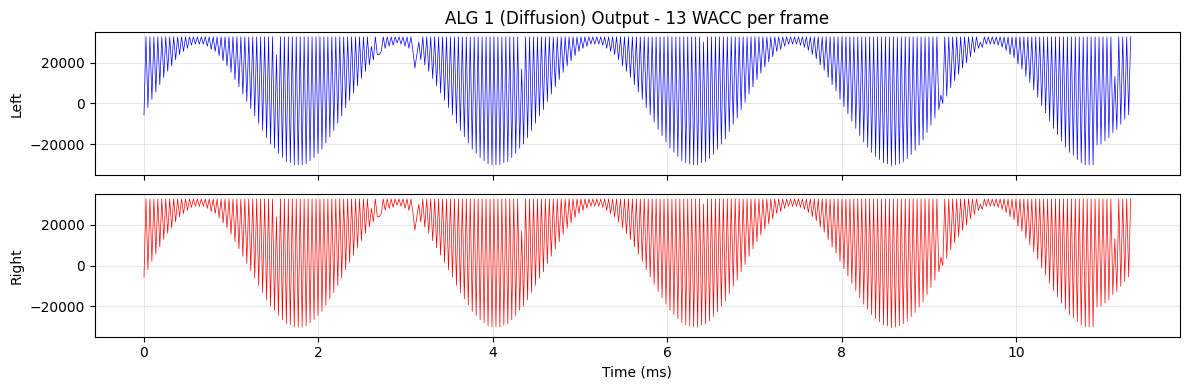


Signal Statistics:
  L channel: mean=16066.08, std=22047.43
  R channel: mean=16066.08, std=22047.43


In [35]:
# Plot output waveform
plot_waveform(samples, title="ALG 1 (Diffusion) Output - 13 WACC per frame")
plt.show()

# Show signal statistics
print("\nSignal Statistics:")
print(f"  L channel: mean={samples[:, 0].mean():.2f}, std={samples[:, 0].std():.2f}")
print(f"  R channel: mean={samples[:, 1].mean():.2f}, std={samples[:, 1].std():.2f}")

## SRAM Read Analysis

Examine which SRAM addresses are read by ALG 1 and how they affect the output.

In [21]:
# Analyze SRAM delay buffer reads
if sram_read_log:
    print(f"=== SRAM Delay Buffer Reads ({len(sram_read_log)} total) ===")
    
    # Count reads per WF bank
    wf_counts = {}
    for entry in sram_read_log:
        frame, addr, result, wf, phi = entry
        wf_counts[wf] = wf_counts.get(wf, 0) + 1
    
    print(f"Reads per WF bank: {dict(sorted(wf_counts.items()))}")
    print(f"Reads per frame: {len(sram_read_log) / NUM_FRAMES:.1f}")
    
    # Count high vs low byte reads
    high_reads = sum(1 for e in sram_read_log if (e[4] & 1) == 0)
    low_reads = sum(1 for e in sram_read_log if (e[4] & 1) == 1)
    print(f"High byte reads (PHI[0]=0): {high_reads}")
    print(f"Low byte reads (PHI[0]=1): {low_reads}")
    
    # Show sample reads with values
    print("\nFirst 20 SRAM reads:")
    for i, entry in enumerate(sram_read_log[:20]):
        frame, addr, result, wf, phi = entry
        byte_type = "HIGH" if (phi & 1) == 0 else "LOW "
        result_signed = result if result < 2048 else result - 4096
        print(f"  Frame {frame}: PHI=0x{phi:03X} [{byte_type}] -> 0x{result:03X}({result_signed:+5d})")
else:
    print("No SRAM delay buffer reads recorded")

# Analyze input sample reads (shouldn't happen for ALG 1)
print()
if input_read_log:
    print(f"=== Input Sample Reads ({len(input_read_log)} total) ===")
    print("NOTE: ALG 1 should NOT read directly from input buffer!")
else:
    print("No direct input reads (expected for ALG 1 - it reads from SRAM delay buffer)")

=== SRAM Delay Buffer Reads (2000 total) ===
Reads per WF bank: {2: 2000}
Reads per frame: 4.0
High byte reads (PHI[0]=0): 750
Low byte reads (PHI[0]=1): 1250

First 20 SRAM reads:
  Frame 0: PHI=0x001 [LOW ] -> 0x000(   +0)
  Frame 0: PHI=0xDBE [HIGH] -> 0x188( +392)
  Frame 0: PHI=0xB42 [HIGH] -> 0xE20( -480)
  Frame 0: PHI=0x7FF [LOW ] -> 0x780(+1920)
  Frame 1: PHI=0x001 [LOW ] -> 0x000(   +0)
  Frame 1: PHI=0xDBF [LOW ] -> 0x430(+1072)
  Frame 1: PHI=0xB43 [LOW ] -> 0x480(+1152)
  Frame 1: PHI=0x800 [HIGH] -> 0x040(  +64)
  Frame 2: PHI=0x001 [LOW ] -> 0x000(   +0)
  Frame 2: PHI=0xDC0 [HIGH] -> 0x1A8( +424)
  Frame 2: PHI=0xB44 [HIGH] -> 0xE38( -456)
  Frame 2: PHI=0x801 [LOW ] -> 0x208( +520)
  Frame 3: PHI=0x001 [LOW ] -> 0x000(   +0)
  Frame 3: PHI=0xDC1 [LOW ] -> 0x738(+1848)
  Frame 3: PHI=0xB45 [LOW ] -> 0x388( +904)
  Frame 3: PHI=0x802 [HIGH] -> 0x000(   +0)
  Frame 4: PHI=0x001 [LOW ] -> 0x000(   +0)
  Frame 4: PHI=0xDC2 [HIGH] -> 0x1C8( +456)
  Frame 4: PHI=0xB46 [HIGH]

## Final State Inspection

In [26]:
print_state(sam.state, slot=5)

SAM8905 Register State
  A = 0x0B180  (+45440)
  B = 0x0EF00  (+61184)
  X = 0x0A0  (+160)
  Y = 0x002  (+2)
  PHI = 0xFB2  (4018)
  WF = 0x002
  MUL = 0x00014  (+20)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = +212992  R_ACC = +212992

D-RAM Slot 5:
  D[ 0] = 0x00080  (+128)
  D[ 1] = 0x00180  (+384)
  D[ 2] = 0x1003F  (+65599)
  D[ 3] = 0x10000  (+65536)
  D[ 4] = 0x00100  (+256)
  D[ 5] = 0x00100  (+256)
  D[ 6] = 0x4F900  (-198400)
  D[ 7] = 0x7D900  (-9984)
  D[ 8] = 0x69B00  (-91392)
  D[ 9] = 0x40402  (-261118)
  D[10] = 0x40402  (-261118)
  D[11] = 0x40402  (-261118)
  D[12] = 0x40402  (-261118)
  D[13] = 0x0B180  (+45440)
  D[14] = 0x40000  (-262144)
  D[15] = 0x3C280  (+246400)


/tmp/ipykernel_1173833/2521777746.py:41: RuntimeWarning: overflow encountered in scalar multiply
  input_scaled = [input_buffer_16bit[i % len(input_buffer_16bit)] * 10 for i in range(200)]


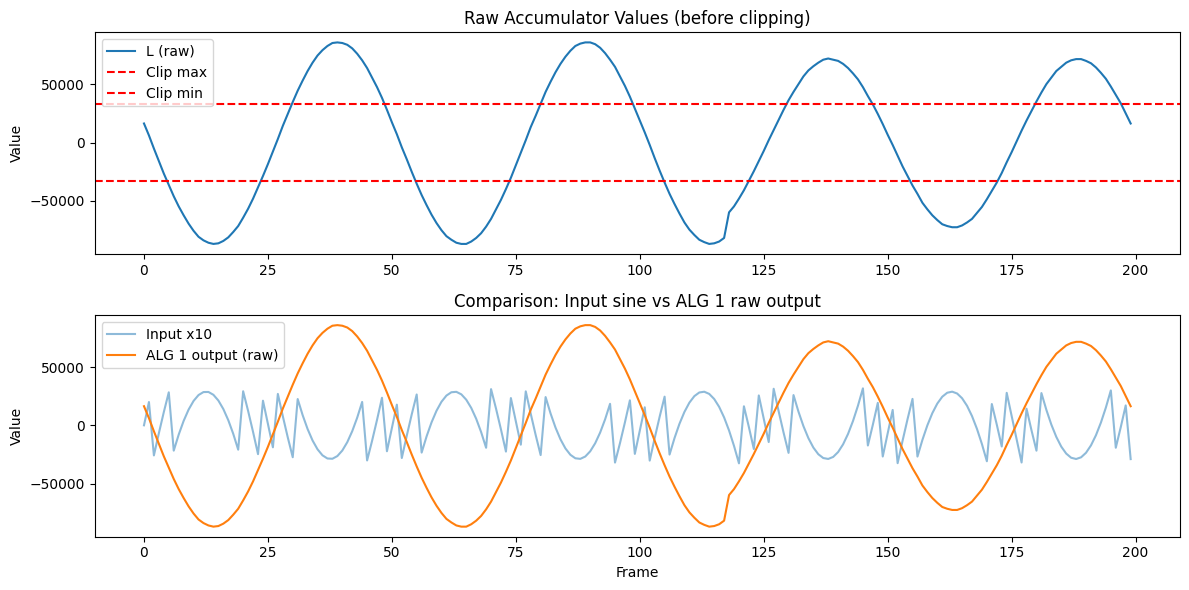


Raw accumulator range: L=[-87016, 86040]
Would clip: 147 / 200 frames


In [11]:
# Examine raw accumulator values before clipping
# The samples array shows clipped values, but let's look at the pattern

# Re-run with tracing to see accumulator values
sam.reset()
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback
sam.state.mix_l = 7
sam.state.mix_r = 7

# Clear logs and run just 50 frames
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Track raw accumulator values per frame
raw_acc_values = []

for i in range(200):
    frame_counter = i
    sam.state.l_acc = 0
    sam.state.r_acc = 0
    sam.execute_frame(active_slots=[5])
    raw_acc_values.append((sam.state.l_acc, sam.state.r_acc))

# Plot raw vs clipped
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

raw_l = [v[0] for v in raw_acc_values]
raw_r = [v[1] for v in raw_acc_values]

axes[0].plot(raw_l, label='L (raw)')
axes[0].axhline(y=32767, color='r', linestyle='--', label='Clip max')
axes[0].axhline(y=-32768, color='r', linestyle='--', label='Clip min')
axes[0].set_title('Raw Accumulator Values (before clipping)')
axes[0].legend()
axes[0].set_ylabel('Value')

# Show input reference (scaled)
input_scaled = [input_buffer_16bit[i % len(input_buffer_16bit)] * 10 for i in range(200)]
axes[1].plot(input_scaled, label='Input x10', alpha=0.5)
axes[1].plot(raw_l, label='ALG 1 output (raw)')
axes[1].set_title('Comparison: Input sine vs ALG 1 raw output')
axes[1].legend()
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

print(f"\nRaw accumulator range: L=[{min(raw_l)}, {max(raw_l)}]")
print(f"Would clip: {sum(1 for v in raw_l if v < -32768 or v > 32767)} / {len(raw_l)} frames")